# Plagiarism Detector

### Shingling + Jaccard Similarity + MiniHash was provided by:
- https://github.com/vgole001/Count-Distinct-Items-using-Min-Hash-and-LSH/blob/master/MinHash_LSH.ipynb
- https://github.com/daanknoors/LSH/blob/master/ItemSimilarity.py
- https://github.com/Pankajdeer/Plagiarism-Detection/blob/main/Plagirism%20Detection%20using%20python.ipynb

We changed some of the stuffs and tried not use their exact code, however, you mentioned that we can use the already implemented classes for Shingling + Jaccard Similarity + MiniHash

In [17]:
from tqdm import tqdm, trange, tqdm_notebook # Printing progress bar
import json
import numpy as np
import binascii
from time import time
from time import sleep
from tqdm import tqdm
import pandas as pd
import string
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import random
import re


### Helper Functions

In [18]:

# Calculate the Jaccard similarity of 2 sets
def jaccardSim(s1,s2):
    s1 = set(s1)
    s2 = set(s2)
    return (len(s1.intersection(s2)) / len(s1.union(s2)))


# Return a random hash function from a universal family
# p = prime number > m
def make_random_hash_function(p=2**33-355, m=2**32-1):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

In [30]:
%%time

News_ID = pd.read_csv("C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Provided Data/news_articles_small.csv")
print(News_ID )

print("")
filename = "C:/Users/Andria.m/Desktop/LSH test/Plagiarism_Detector-LSH/Provided Data/news_articles_small.txt"



     News_ID                                            article
0          0  The Supreme Court in Johnnesberg on Friday pos...
1          1  The IG Metall union has decided not to spread ...
2          2  Malaysia said Friday it had no plans to overre...
3          3  South Korea is redoubling its efforts behind K...
4          4  The Philippine subsidiary of US telecommunicat...
..       ...                                                ...
995      995  Shares here fell early on Friday as dealers to...
996      996  Forty-five thousand Rwandan refugees were on t...
997      997  Australian shares closed sharply higher on Fri...
998      998  The president of the Long-Term Credit Bank of ...
999      999  The Shanghai-based China Foreign Exchange Trad...

[1000 rows x 2 columns]

Wall time: 32 ms


## Read input file and preprocess data
- reading all of the words (they are all in one line) and split them by white space.
- retrieve the article ID which is the first column in the file.
- converting words to lowercase, and removing any tabs, new lines, e.t.c

In [550]:
#Read input file and preprocess data
%%time
class Parser():
    def parse_input_file(self, filename):
        data_list = []
        with open(filename) as ff:
            contents = ff.readlines()
            for line in contents:
                doc_id_word = ()
                # read all of the words (they are all in one line) and split them by white space
                words = line.split(" ")
#                print(words)
                # retrieve the article ID which is the first word on the line
                docID = words[0]
#                 print(docID)
                del(words[0])

                word_list = []
                for word in words:
                    # make words lowercase
                    word = word.lower()
                    # remove any tabs, new lines, e.t.c
                    word = re.sub(r'[^\w]','',word)
                    word_list.append(word)
                word_list = ''.join(word_list)
                doc_id_word = (docID,word_list)
                data_list.append(doc_id_word)
            return data_list
        

In [551]:
parser = Parser()
data = parser.parse_input_file(filename)
# print(data)

In [552]:
# Create proper data structures for our data
hash_num = 50
shingles_len = 10

### Shingling + Jaccard Similarity + MiniHash 

In [554]:
%%time
class ProcessData():
    def map_doc_id(self, docIds):
        docIdMap = {}
        for i in range(0, len(docIds)):
            docIdMap[docIds[i]] = i
        return docIdMap

    
    
    
    def invert_shingles(self,tuples,ids):
        # Compute the hash value for each of our word in document
        shingles_list= list()
        for d in data:
            hash_shingles = set()
            for i in range(0, len(d[1]) - shingles_len + 1):
                hash_value = binascii.crc32(d[1][i: i + shingles_len].encode('utf-8')) & 0xffffffff
                hash_shingles.add(hash_value)
            shingles_list.append((d[0],hash_shingles))
    
        # Invert shingles so shingles become rows and docId's become columns
        for row in shingles_list:
            ids.append(row[0])
            for s in row[1]:
                tuples.append((s,row[0]))
        return tuples,ids
        print(tuples)
    
    
    
    
    def add_hash_functions(self):
        hash_funcs = []
        # Make hash functions
        for i in range(0, hash_num):
            hash_funcs.append(make_random_hash_function())
        return hash_funcs
    
    
    
    
    def calc_signature_matrix(self, num_docs):
        tuples = []
        ids = []
        hash_funcs = []
        tuples,ids = self.invert_shingles(tuples,ids)
        hash_funcs = self.add_hash_functions()
         # Initialize signature matrix values to infinity
        sigmatrix = np.full([hash_num, num_docs], np.inf)
        
        print('sigmatrix shape: ',sigmatrix.shape)
        doc_id_col_map = self.map_doc_id(ids)
        
        

        # Update signature matrix values
        row = 0
        for item, id in tuples:
            j = doc_id_col_map[id]
            for n in range(0, len(hash_funcs)):
                sigmatrix[n][j]= min(hash_funcs[n](item), sigmatrix[n][j])
        return sigmatrix, doc_id_col_map
    
    

## Min Hash Similarity Class
Compute similarity for signature matrix based on jaccard similarity

Compute Jaccard similarity 
In this section we will compute Jaccard similarity for shingles with the utility function for later comparison with MinHash and LSH accuracy. The [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) is defined as: 
$$ J(A,B)={{|A\cap B|} \over {|A\cup B|}}={{|A\cap B|} \over {|A|+|B|-|A\cap B|}}. $$

Therefore, two documents $A$ and $B$ will be similar is they have common shingles.

In [560]:
%%time
# Min Hash Similarity Class
class MinHashSimilarity():  
    def CalculateSimilarity(self, num_docs):
        preprocess = ProcessData()
    
        sigmatrix,doc_id_col_map = preprocess.calc_signature_matrix(num_docs)
        
        # Compute similarity for signature matrix based on jaccard similarity
        sim_sets = []
        sigmatrix = np.array(sigmatrix)
        for i in range(0, sigmatrix.shape[1]-1):
            s1 = sigmatrix[:,i]
            for j in range(i + 1, sigmatrix.shape[1]):
                s2 = sigmatrix[:,j]
                sim = jaccardSim(s1,s2)
                
                
                if sim > 0.8:
                    d1Str = list(doc_id_col_map.keys())[i]
                    d2Str = list(doc_id_col_map.keys())[j]
                    sim_sets.append((d1Str,d2Str,round(sim,4)))
#                   print(sim_sets)
        return sim_sets
        

In [561]:
%%time
print("")
# Run the Min Hash algorithm on different size files, count their response time and write output to a file
min_hash_similarity = MinHashSimilarity()
start_time = time()

num_of_doc = (len(data))
print(num_of_doc)

similarities = min_hash_similarity.CalculateSimilarity(len(data))
end_time = time()
est_time = end_time - start_time
print("1_IDs "," 2_IDs" )
for x in similarities:
    for y in x:
        
        print(y, end=' \t ')
    print()


1000
sigmatrix shape:  (21, 1000)
1_IDs   2_IDs
103 	 205 	 0.9091 	 
122 	 523 	 1.0 	 
151 	 480 	 1.0 	 
197 	 544 	 1.0 	 
198 	 373 	 1.0 	 
264 	 880 	 1.0 	 
282 	 918 	 0.9091 	 
289 	 746 	 1.0 	 
332 	 802 	 1.0 	 
372 	 774 	 1.0 	 
Wall time: 2min 10s


In [562]:
print(similarities)

[('103', '205', 0.9091), ('122', '523', 1.0), ('151', '480', 1.0), ('197', '544', 1.0), ('198', '373', 1.0), ('264', '880', 1.0), ('282', '918', 0.9091), ('289', '746', 1.0), ('332', '802', 1.0), ('372', '774', 1.0)]


In [563]:

if est_time > 60.0:
    print('Execution time for %d articles: %f minutes'%(len(data),est_time/60.0))
else:
    print('Execution time for %d articles: %f seconds'%(len(data),est_time))
    print()

print("1_IDs   2_IDs  Similarities")
for sims in similarities:
   
    print("----------------------------------------------------")
    print('\t '.join('%s' % s for s in sims))
    

Execution time for 1000 articles: 2.167670 minutes
1_IDs   2_IDs  Similarities
----------------------------------------------------
103	 205	 0.9091
----------------------------------------------------
122	 523	 1.0
----------------------------------------------------
151	 480	 1.0
----------------------------------------------------
197	 544	 1.0
----------------------------------------------------
198	 373	 1.0
----------------------------------------------------
264	 880	 1.0
----------------------------------------------------
282	 918	 0.9091
----------------------------------------------------
289	 746	 1.0
----------------------------------------------------
332	 802	 1.0
----------------------------------------------------
372	 774	 1.0


In [540]:
# Write similar pair documents to a file
with open('Jaccard_Similar_Documents.txt', 'w+') as fp:
    fp.write('Similarity between documents using the MinHash Method: \n')
    for sims in similarities:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()


In [16]:
# Files for Localiry Sensitive Hashing Similarity Part
# 1-(1-0.80^r)^b = 0.99

shingles_len = 10
hash_num = 50
bands_num = 10
rows = int(hash_num / bands_num)
# s = (1/bands_num)**(1/rows)
s = 0.80

print("Bands num: ",bands_num,', rows/band: ',rows,", threshold s: ",s)
a=s**rows
x=(1-a)**bands_num
prob=round(1-x,4)
print("Prob. that at least 1 band is identical: ",prob)
print("-------------------------------------------------------------")
print("Chanse of False Negative in 80% Similarity: ",round(x,4)," => ",round(100*x,3),"%")
print()

s1=0.5
a=s1**rows
x=(1-a)**bands_num
prob2=round(1-x,4)
print("Chanse of False Positive in 50% Similarity: ",round(prob2,4)," => ",round(100*prob2,3),"%")
print()


Bands num:  10 , rows/band:  5 , threshold s:  0.8
Prob. that at least 1 band is identical:  0.9811
-------------------------------------------------------------
Chanse of False Negative in 80% Similarity:  0.0189  =>  1.887 %

Chanse of False Positive in 50% Similarity:  0.272  =>  27.2 %



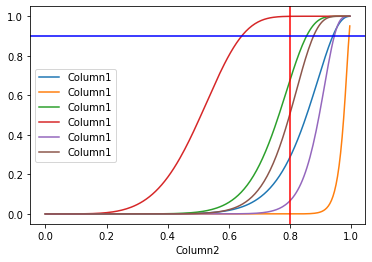

In [26]:
# b=[2,50,10,5,20,50,20]
# r=[50,2,10,20,5,20,50]


thresh = np.arange(0,1.0,0.005)
br_lst = [(10,3),(50,2),(10,10),(5,20),(20,6),(12,10)]
ax = None
for k in br_lst:
  p=[];b=k[0];r=k[1]
  for t in thresh:
    p.append(1-(1-(t**b))**r)
    
  df = pd.DataFrame({'Column1':p, 'Column2':thresh})
  ax = df.plot(ax=ax,x='Column2',y='Column1')
ax.axvline(x=0.8,color='r')
ax.axhline(y=0.9,color='b')
#   plt.rcParams['figure.figsize'] = [12,12]

## Locality Sensitive Hashing 
Implemented based on the LSH class in the LSH-TEST

In [544]:
import scipy as opt

shingles_len = 10
hash_num = 50
bands_num = 10
rows = int(hash_num / bands_num)
# s = (1/bands_num)**(1/rows)
s = 0.80



class LSHSimilarity():
    def __init__(self, num_docs):
        self.num_docs = num_docs
        
        
#     same as the previous one 
    def hash_vector(self, hash_fnctions, vector , m = 2**32-1):
        sum = 0
        for i in range(len(vector)):
            h = hash_fnctions[i]
            sum += h(vector[i])
        return sum % m

    
    
    def CalculateSimilarity(self, sigmatrix):
        
        
        preprocess = ProcessData()
        hash_funcs = preprocess.add_hash_functions()
        sigmatrix, doc_id_col_map = preprocess.calc_signature_matrix(self.num_docs)
        
        
        # Compute similarity for signature matrix based on jaccard similarity
        sim_sets = []
        sigmatrix = np.array(sigmatrix)

#         error_fun = lambda x: (threshold-((1/x[0])**(x[0]/hash_num)))**2
#         res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
#         bands_num = int(math.ceil(res['x'][0]))

        # Initialize the number of bands and threshold
#         bands_num = 8
#         print(bands_num)

        # Calculate number of rows needed for each band
#         rows = int(hash_num / bands_num)

#        s = pow((1/bands_num),1/rows)
#         s = (1/bands_num)**(1/rows)
#         print('rows threshold: ',rows," threshold s:",s)
        
    
        buckets = []
        bucket_dic = defaultdict(list)

        pairs = set()

        for r in range(bands_num):
            start_row = r * rows
            end_row = start_row + rows

            for doc in range(self.num_docs):
                hash_vec = self.hash_vector(hash_funcs,sigmatrix[start_row:end_row,doc])
                bucket_dic[hash_vec].append(doc)
                #print('bucket',bucket_dic.items())

        for item, value in bucket_dic.items():
            if len(value) > 1:
                pairs.add(tuple(value))

        sim_docs = []
        for s in pairs:
            d1 = list(doc_id_col_map.keys())[s[0]]
            d2 = list(doc_id_col_map.keys())[s[1]]
            sim_docs.append((d1,d2))

        # Get candidate pairs that hash to the same bucket at least once
        return sim_docs
    

In [545]:
%%time
print()
sigmatrix = []
start_time = time()
lsh_similarity = LSHSimilarity(len(data))
similarities = lsh_similarity.CalculateSimilarity(sigmatrix)
end_time = time()
est_time = end_time - start_time
if est_time > 60.0:
    print('Execution time for %d articles: %f minutes'%(len(data),est_time/60.0))
else:
    print('Execution time for %d articles: %f seconds'%(len(data),est_time))


sigmatrix shape:  (21, 1000)
Execution time for 1000 articles: 1.018728 minutes
Wall time: 1min 1s


In [546]:
# Write similar pair documents to a file
with open('LSH_Similar_Pairs.txt', 'w+') as fp:
    fp.write('Similarity between documents using the LSH Method: \n')
    for sims in similarities:
        fp.write('\t'.join('%s' % s for s in sims))
        fp.write('')
        fp.write('\n')
fp.close()

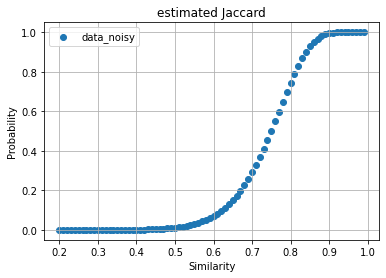

In [28]:
prob = []
sim = [x for x in np.arange(0.2, 1.0, 0.01)]
for s in sim:
    prob.append((1-pow((1-pow(s,r)),b)))

x = sim
y = prob

fig, ax = plt.subplots()
ax.scatter(x, y, label='data_noisy')
ax.set_title('estimated Jaccard')
ax.set_xlabel('Similarity') 
ax.set_ylabel('Probability')
ax.grid()
leg = ax.legend()

plt.show()
# plt.rcParams['figure.figsize'] = [10,10]

## References

- https://medium.com/analytics-vidhya/locality-sensitive-hashing-finding-documents-similarity-6f12d4d83af
- https://www.researchgate.net/publication/291225480_Locality-Sensitive_Hashing_Techniques_for_Nearest_Neighbor_Search
- http://www.cs.uoi.gr/~tsap/teaching/2016-cse012/slides/datamining-lect5.pdf
- https://github.com/CostasPitharoulios/Plagiarism_Detector/blob/master/Jupyter_Notebook/PlagiarismsDetector.ipynb
- https://cse.iitkgp.ac.in/~animeshm/algoml/lsh.pdf
- https://github.com/himalayanZephyr/finding_similar_documents/blob/master/similar_items.ipynb
- https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/
- https://cse.iitkgp.ac.in/~sourangshu/coursefiles/SDM18A/07-LSH-1.pdf
- https://github.com/elhamsharifi?tab=repositories
- https://unboxresearch.com/articles/lsh_post1.html
- https://github.com/vgole001/Count-Distinct-Items-using-Min-Hash-and-LSH/blob/master/MinHash_LSH.ipynb
- https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134
- https://github.com/Pankajdeer/Plagiarism-Detection/blob/main/Plagirism%20Detection%20using%20python.ipynb
- https://www.sciencedirect.com/science/article/abs/pii/S0957417418300149
- https://github.com/davidtag/cs166-project/blob/master/Experiment_Starter.ipynb
- https://www.researchgate.net/publication/291225480_Locality-Sensitive_Hashing_Techniques_for_Nearest_Neighbor_Search
- https://github.com/pyt243/IR-LSH
